# NDVI over Sentinel-2 imagery in the focus region

In [3]:
import geopandas as gpd
import rasterio as rio
from pathlib import Path
import datetime
from shapely.geometry import box
import matplotlib.pyplot as plt
import contextily as ctx
import math
import numpy as np
import folium

from copy import deepcopy

# this script directory in jupyterlab
script_dir = Path.cwd()


In [4]:
def load_custom_frontline() -> gpd.GeoDataFrame:
    """
    Load the shapefile for the focus region
    Author: jan mattis töller

    Args:
        None
    Returns:
        shapefile_focus_region (gpd.GeoDataFrame): The shapefile for the focus region
    """
    shapefile_path = script_dir / "data" / "source" / "frontlinie.shp"
    shapefile_focus_region = gpd.read_file(shapefile_path)

    assert isinstance(shapefile_focus_region, gpd.GeoDataFrame), "shapefile_focus_region is not a GeoDataFrame"
    return shapefile_focus_region

def load_all_frontlines_nzz_maps() -> dict:
    """
    Load all frontlines from conflict investigations NZZ Maps 
    Source: https://github.com/conflict-investigations/nzz-maps
    Author: Ben Kraas
    Args:
        None
    Returns:
        frontline_dict (dict): A dictionary containing the frontlines for each date
    """
    directory = script_dir / "data" / "source" / "nzz-maps"

    frontline_dict = {}

    for geojsonfile in directory.iterdir():
        # Load the GeoJSON file
        gdf = gpd.read_file(geojsonfile)

        # Convert to WGS84
        gdf = gdf.to_crs(epsg=4326)

        # If the file contains a multipolygon, unify it to a single polygon into a union_gdf
        if gdf.geometry.geom_type[0] == "MultiPolygon":
            union_gdf = gdf.union_all()
            union_gdf = gpd.GeoDataFrame(geometry=[union_gdf], crs=gdf.crs)
            union_gdf = union_gdf.to_crs(epsg=4326)
        else:
            union_gdf = gdf

        # Get date form filename
        date_str = geojsonfile.stem.split(".")[0]
        date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
        
        print(f"Loaded {geojsonfile.name} with date {date}")

        frontline_dict[date_str] = {
            "gdf": gdf,
            "union_gdf": union_gdf,
            "date": date,
            "metadata": {
                "name": geojsonfile.name,
                "path": geojsonfile,
                "data_crs": gdf.crs,
                "data_bbox": gdf.total_bounds,
            }
        }

        assert isinstance(gdf, gpd.GeoDataFrame), f"gdf is not a GeoDataFrame: {geojsonfile.name}"
        assert gdf.crs == "EPSG:4326", f"gdf is not in WGS84: {geojsonfile.name}"
        assert gdf.shape[0] > 0, f"gdf is empty: {geojsonfile.name}"
        assert isinstance(date, datetime.date), f"date is not a datetime object: {geojsonfile.name}"


    return frontline_dict


   FID                                           geometry
0    0  POLYGON ((37.94102 50.01651, 37.85176 49.97148...


/home/ben/.local/share/mamba/envs/GIS1/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


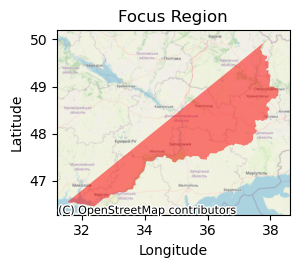

In [5]:
focus_region = load_custom_frontline()
print(focus_region)

# plot the focus region with basemap
fig, ax = plt.subplots(figsize=(3, 3))
focus_region.plot(ax=ax, color='red', alpha=0.5)
ax.set_title("Focus Region")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# add basemap OSM
ctx.add_basemap(ax, crs=focus_region.crs.to_proj4(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

Loaded 2025-03-01.json with date 2025-03-01
Loaded 2024-03-01.json with date 2024-03-01
Loaded 2022-03-01.json with date 2022-03-01
Loaded 2023-03-01.json with date 2023-03-01


/home/ben/.local/share/mamba/envs/GIS1/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ben/.local/share/mamba/envs/GIS1/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ben/.local/share/mamba/envs/GIS1/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coo

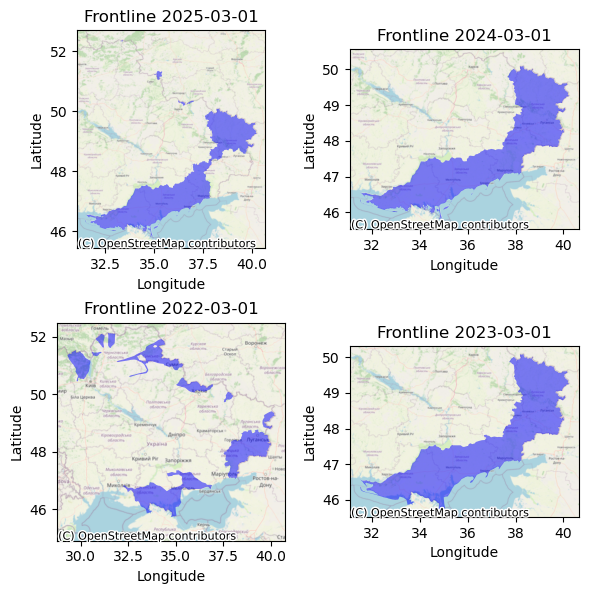

In [6]:
# In four subplots, show the four frontlines
frontline_dict = load_all_frontlines_nzz_maps()

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
for key, value in frontline_dict.items():
    try :
        gdf = value["union_gdf"]
    except KeyError:
        print(f"KeyError: {key} does not have a union_gdf, using gdf instead")
        gdf = value["gdf"]
        
    date = value["date"]
    ax = axs.flatten()[list(frontline_dict.keys()).index(key)]
    gdf.plot(ax=ax, color='blue', alpha=0.5)
    ax.set_title(f"Frontline {date}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    # add basemap OSM
    ctx.add_basemap(ax, crs=gdf.crs.to_proj4(version=5), source=ctx.providers.OpenStreetMap.Mapnik)
    
plt.tight_layout()
plt.show()

/home/ben/.local/share/mamba/envs/GIS1/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/tmp/ipykernel_1263/3744814182.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title="Dates")
/tmp/ipykernel_1263/3744814182.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Dates")


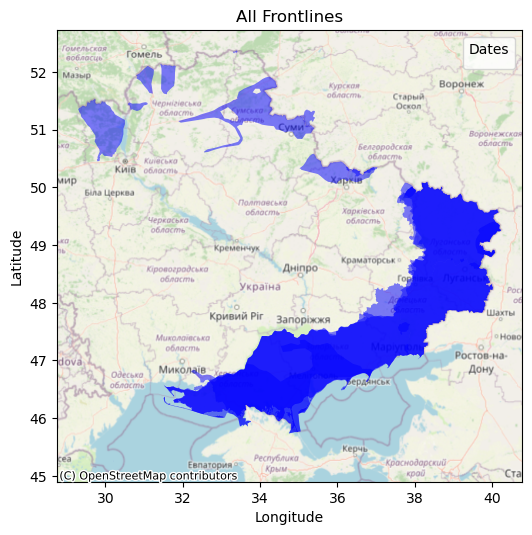

In [7]:
# Plot all four frontlines in one plot
fig, ax = plt.subplots(figsize=(6, 6))
for key, value in frontline_dict.items():
    try:
        gdf = value["union_gdf"]
    except KeyError:
        print(f"KeyError: {key} does not have a union_gdf, using gdf instead")
        gdf = value["gdf"]
        
    date = value["date"]
    # plot the frontline
    gdf.plot(ax=ax, color='blue', alpha=0.5, label=str(date))

# Add basemap OSM
ctx.add_basemap(ax, crs=gdf.crs.to_proj4(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set plot title and labels
ax.set_title("All Frontlines")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(title="Dates")

Polygon 14 bbox: [36.509716325140886, 47.66084708529761, 37.95844, 48.4732908887411]


/home/ben/.local/share/mamba/envs/GIS1/lib/python3.13/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


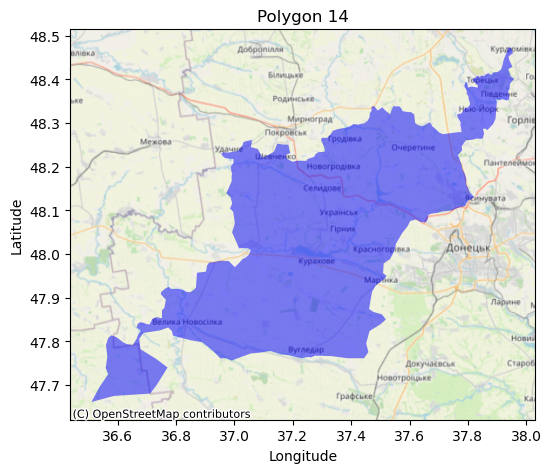

In [8]:
# subtract the frontline from 2023-03-01 from the frontline from 2025-03-01
frontline_2023 = frontline_dict["2023-03-01"]["union_gdf"]
frontline_2025 = frontline_dict["2025-03-01"]["union_gdf"]
frontline_diff = frontline_2025.difference(frontline_2023, align=True)

# Split non-connected polygons into separate polygons of the geodataframe
frontline_diff = frontline_diff.explode(index_parts=True)
frontline_diff = frontline_diff.reset_index(drop=True)
# Convert to GeoDataFrame
frontline_diff = gpd.GeoDataFrame(frontline_diff, columns=['geometry'])

# Add an index column to the geodataframe
frontline_diff['index'] = frontline_diff.index

# Save the frontline difference to a geojson file
output_path = script_dir / "data" / "output" / "frontline_diff_2023_2025.geojson"
frontline_diff.to_file(output_path, driver='GeoJSON')

# Save polygon #14 to a geojson file (This is the main AOI)
polygon_14 = frontline_diff.iloc[14:15]  # Use slicing to maintain GeoDataFrame structure
polygon_14.to_file(script_dir / "data" / "output" / "main_region.geojson", driver='GeoJSON')
# print bbox
print(f"Polygon 14 bbox: {[float(x) for x in list(polygon_14.total_bounds)]}")

fig, ax = plt.subplots(figsize=(6, 6))
polygon_14.plot(ax=ax, color='blue', alpha=0.5)
ax.set_title("Polygon 14")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# add basemap OSM
ctx.add_basemap(ax, crs=polygon_14.crs.to_proj4(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

# polygon_14.explore()

In [9]:
def load_geotiff(path: Path) -> gpd.GeoDataFrame:
    """
    Load the geotiff file as a rasterio object
    Args: 
        path (Path): Path to the geotiff file
    Returns: 
        geodataframe (gpd.GeoDataFrame): The geopandas GeoDataFrame
    """
    with rio.open(path) as src:
        # Read the geotiff file as a numpy array
        data = src.read()
        meta = src.meta

        geodataframe = gpd.GeoDataFrame(
            data=data,
            crs=meta['crs'],
            geometry=[box(*src.bounds)],
        )
    
    assert isinstance(geodataframe, gpd.GeoDataFrame), "geodataframe is not a GeoDataFrame"
    return geodataframe

In [10]:
def index_NDVI(geodataframe: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Index the NDVI
    Args:
        geodataframe (gpd.GeoDataFrame): The geopandas GeoDataFrame
    Returns:
        indexed_geodataframe (gpd.GeoDataFrame): The indexed geopandas GeoDataFrame
    """
    # Assuming the GeoDataFrame has columns 'NIR' and 'Red' for the respective bands
    if 'NIR' not in geodataframe.columns or 'Red' not in geodataframe.columns:
        raise ValueError("GeoDataFrame must contain 'NIR' and 'Red' columns")

    # Calculate NDVI
    geodataframe['NDVI'] = (geodataframe['NIR'] - geodataframe['Red']) / (geodataframe['NIR'] + geodataframe['Red'])

    assert isinstance(geodataframe, gpd.GeoDataFrame), "indexed_geodataframe is not a GeoDataFrame"
    return geodataframe

In [11]:
def calculate_raster_difference(geodataframe1: gpd.GeoDataFrame, geodataframe2: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Calculate the difference between two rasters
    Args:
        geodataframe1 (gpd.GeoDataFrame): The first geopandas GeoDataFrame
        geodataframe2 (gpd.GeoDataFrame): The second geopandas GeoDataFrame
    Returns:
        difference_geodataframe (gpd.GeoDataFrame): The difference geopandas GeoDataFrame
    """
    # Ensure both GeoDataFrames have the same columns
    if not geodataframe1.columns.equals(geodataframe2.columns):
        raise ValueError("GeoDataFrames must have the same columns")

    # Calculate the difference for each column except 'geometry'
    difference_data = {}
    for column in geodataframe1.columns:
        if column != 'geometry':
            difference_data[column] = geodataframe1[column] - geodataframe2[column]

    # Create a new GeoDataFrame with the difference data
    difference_geodataframe = gpd.GeoDataFrame(difference_data, 
                                               crs=geodataframe1.crs, 
                                               geometry=geodataframe1.geometry)

    assert isinstance(difference_geodataframe, gpd.GeoDataFrame), "difference_geodataframe is not a GeoDataFrame"
    return difference_geodataframe

In [ ]:
# Hauptskript

# Load the focus region
shapefile_focus_region = load_custom_frontline()

# Load the geotiff file as a rasterio object
raster_old = load_geotiff(Path("path_to_geotiff_file_old"))
raster_new = load_geotiff(Path("path_to_geotiff_file_new"))

# Calculate the NDVI indexs 
NDVI_old = index_NDVI(raster_old)
NDVI_new = index_NDVI(raster_new)

# Calculate the difference between the two rasters
difference = calculate_raster_difference(NDVI_old, NDVI_new)

print("Success!")